<a href="https://colab.research.google.com/github/amirhoseinoveis/SHAP-with-MSTAR/blob/main/SHAP-with-MSTAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Let's import the necessary libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import os


**You can download the MSTAR database - only 3 classes for this example - from my GitHub page**

In [2]:
github_url = 'https://raw.githubusercontent.com/amirhoseinoveis/SHAP-with-MSTAR/cc1bd0d7f7157780d75e2a6855640eec948f732c/mstar_3cl_32by32.npz'

# Download the file using wget
path = '/content/mstar_3cl_32by32.npz'
os.system(f'wget {github_url} -O {path}')

# Load the data using np.load
with np.load(path) as data_mstar:
    x_train_mstar = data_mstar['x_train']
    y_train_mstar = data_mstar['y_train']
    x_test_mstar = data_mstar['x_test']
    y_test_mstar = data_mstar['y_test']

**Let’s define a very simple CNN using the Tensorflow.keras library as**





In [3]:

inputs = Input(shape=(32,32,1),name="Input")
x = Conv2D(32, 3, activation="relu", padding='same',name='Conv1')(inputs)
x = MaxPooling2D(2,name='Pool1')(x)
x = Conv2D(16, 3, activation="relu",padding='same',name='Conv2')(x)
x = MaxPooling2D(2,name='Pool2')(x)
x = Flatten(name='Vectorize')(x)
x= Dense(3,name='FC')(x)
outputs= Activation("softmax",name='Softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 32, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 16, 16, 16)        4624      
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 16)          0         
                                                                 
 Vectorize (Flatten)         (None, 1024)              0         
                                                                 
 FC (Dense)                  (None, 3)                 3075  

**Now we train the model by the training database.**

In [4]:

hist = model.fit(
x_train_mstar,
to_categorical(y_train_mstar, 3),  # One-hot encode your labels
batch_size=32,
epochs=10,
validation_split=0.15,
shuffle='on',
)


Epoch 1/10
19/19 [==============================] - 7s 222ms/step - loss: 1.0744 - acc: 0.3435 - val_loss: 1.0330 - val_acc: 0.3333
Epoch 2/10
19/19 [==============================] - 6s 343ms/step - loss: 0.9966 - acc: 0.4788 - val_loss: 0.9124 - val_acc: 0.5619
Epoch 3/10
19/19 [==============================] - 3s 144ms/step - loss: 0.9006 - acc: 0.5499 - val_loss: 0.8082 - val_acc: 0.5714
Epoch 4/10
19/19 [==============================] - 2s 109ms/step - loss: 0.8117 - acc: 0.6176 - val_loss: 0.7497 - val_acc: 0.6286
Epoch 5/10
19/19 [==============================] - 2s 126ms/step - loss: 0.7486 - acc: 0.6650 - val_loss: 0.7073 - val_acc: 0.6952
Epoch 6/10
19/19 [==============================] - 1s 45ms/step - loss: 0.7036 - acc: 0.6954 - val_loss: 0.6465 - val_acc: 0.7333
Epoch 7/10
19/19 [==============================] - 2s 97ms/step - loss: 0.6183 - acc: 0.7428 - val_loss: 0.5670 - val_acc: 0.7905
Epoch 8/10
19/19 [==============================] - 1s 36ms/step - loss: 0.504

**We can visulize the training process over different epochs**

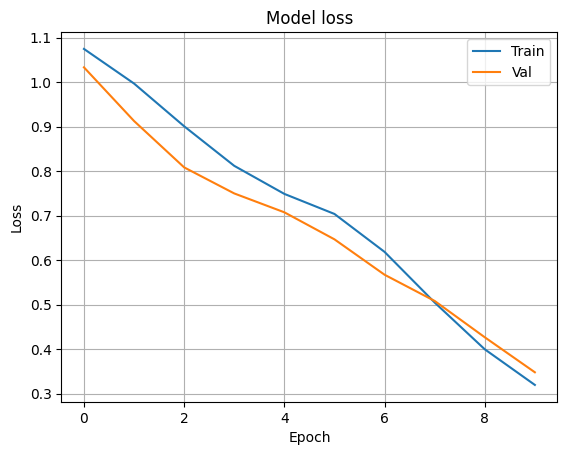

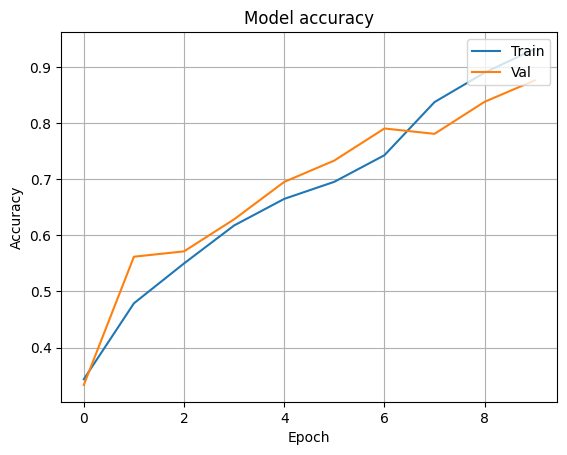

In [5]:

plt.figure(1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.grid("on")
plt.show()

plt.figure(3)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.grid("on")
plt.show()


**After training, the network can predict the class of the test database:**

In [6]:
classes_in=[0,1,2]
y_hat=model.predict(x_test_mstar)#test the model, prob.

y_hat_cl=y_hat.argmax(1) #prob. to class
CM=np.zeros([len(classes_in),len(classes_in)])# Confusion matrix,
for k in range(y_test_mstar.shape[0]):
    CM[y_test_mstar[k],y_hat_cl[k]]=CM[y_test_mstar[k],y_hat_cl[k]]+1

# Display confusion matrix
print("Confusion Matrix:")
for i in range(len(classes_in)):
    row_str = "| "
    for j in range(len(classes_in)):
        row_str += f"{int(CM[i, j]):>4} | "
    print(row_str)
print('Acc=',np.sum(y_hat_cl==y_test_mstar)/y_test_mstar.shape[0])

26/26 [==============================] - 0s 10ms/step
Confusion Matrix:
|  210 |   61 |    3 | 
|    4 |  265 |    5 | 
|    1 |    1 |  272 | 
Acc= 0.9087591240875912





  

**Now Install SHAP**

















>>>>> 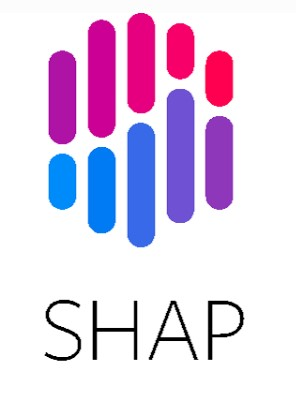

In [7]:
pip install shap

In [8]:
import shap

 **Let's use shap.Explainer, a general method applicable to any model using a masker to perturb the input images.**


In [14]:
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(64,64)", x_test_mstar[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(3)))



**We can use the pre-trained model and a test image (the 600th image, which belongs to class 2).**

**SHAP produces three output images, since our model has 3 classes (we have intentionally set it to three to make it simple).**

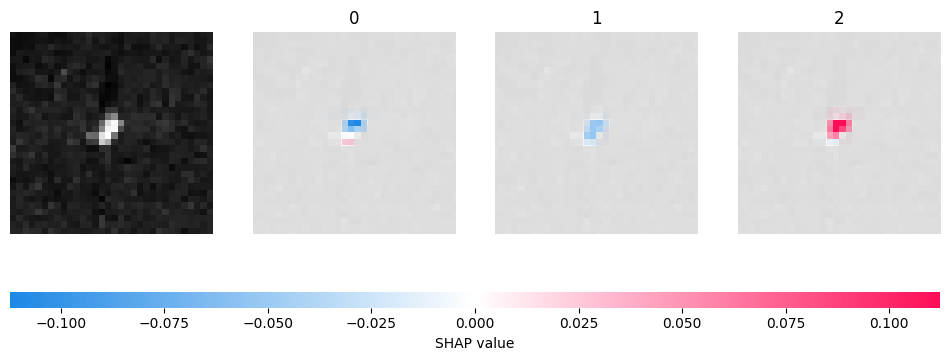

In [15]:
ind=[600]
shap_values_ = explainer( x_test_mstar[ind], max_evals=5000, batch_size=50 )
shap.image_plot(shap_values_,labels=[0,1,2])


 **In each output image, each pixel has a different value. Pixels with positive values are shown in red, and pixels with negative values are shown in blue.**

**Another way to utilize SHAP is by using a set of background samples. This is an enhanced version of the DeepLIFT algorithm (Deep SHAP).**

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


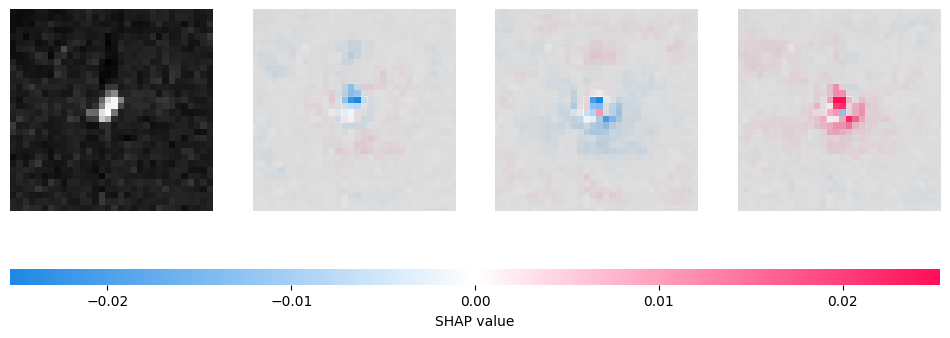

In [18]:
background = x_train_mstar[np.random.choice(x_train_mstar.shape[0], 100, replace=False)]
e = shap.DeepExplainer(model, background)
ind=[600]
shap_values = e.shap_values( x_test_mstar[ind])
shap.image_plot(shap_values,x_test_mstar[ind])


**The new results for the same test image show a bit more influence from the surrounding pixels. This shows how each pixel contributes to the outcome.**